# Title: PCA_SVM vs CNN under Multi-class Image classification
# Author: Omkareswara Reddy, Ganda
## Motivation of the Project: Trying to find out whether we can improve the basic Machine learning models to the level of Deep learning models fine tuning the paramaeters

In [83]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from matplotlib.image import imread
import cv2
import random
from skimage import io, color
import os
import tensorflow as tf

# PCA_SVM Model

In [84]:
X_train = []
y_train = []
X_test = []
y_test = []

train_path = r"data\seg_train\\"
test_path = r"data\seg_test\\"
folder_paths = [train_path, test_path]
classes = {"buildings": 0, "forest": 1, "glacier" : 2, "mountain": 3, "sea": 4, "street": 5}

num_images = 100

for cls in classes:
    new_train_path = train_path + cls
    new_test_path = test_path + cls
    train_files = os.listdir(new_train_path)
    test_files = os.listdir(new_test_path)
    for i in range(num_images):
        file_path = os.path.join(new_train_path, train_files[i])
        if file_path.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            
            # Read the image using matplotlib.image
            image = color.rgb2gray(io.imread(file_path))
            # Append the image to the array
            X_train.append(cv2.resize(image,(150, 150)))
            y_train.append(classes[cls])
    for j in range(num_images):
        file_path = os.path.join(new_test_path, test_files[j])
        if file_path.endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
            
            # Read the image using matplotlib.image
            image = color.rgb2gray(io.imread(file_path))
            # Append the image to the array
            X_test.append(cv2.resize(image,(150, 150)))
            y_test.append(classes[cls])


In [85]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

### Applying PCA on the Train and Test data

In [86]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

pca = PCA(n_components=460)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

### Shuffling the data

In [87]:
train_combined_data = list(zip(X_train_scaled, y_train))
test_combined_data = list(zip(X_test_scaled, y_test))
pca_test_combined_data = list(zip(X_test_pca, y_test))
pca_train_combined_data = list(zip(X_train_pca, y_train))
random.shuffle(train_combined_data)
random.shuffle(test_combined_data)
random.shuffle(pca_test_combined_data)
random.shuffle(pca_train_combined_data)
X_train_scaled, y_train = zip(*train_combined_data)
X_test_scaled, y_test = zip(*test_combined_data)
X_test_pca, y_test = zip(*pca_test_combined_data)
X_train_pca, y_train = zip(*pca_train_combined_data)

## Support Vector Machine Model

### A shocking discovery that after getting very poor results even after intense hyper parameter fine tuning
### After doing the reasearch, found out that SVM is not that much suitable for a multi-class image classification for large datasets

In [91]:
model_svm = SVC( C = 0.1)
model_svm.fit(X_train_scaled, y_train)
model_svm.score(X_test, y_test)

0.15

In [92]:
model_svm.fit(X_train_pca, y_train)
model_svm.score(X_test_pca, y_test)

0.19166666666666668

## Using the PCA and SVM methods, I tried to build the models below and tried to compare the CNN models with the CNN models that involved the PCA or SVM or both

# 1. Load the Data using the tensorflow keras

In [96]:
train_data = tf.keras.utils.image_dataset_from_directory("data\seg_train", image_size=(150,150))
test_data = tf.keras.utils.image_dataset_from_directory("data\seg_test", image_size=(150,150))

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Applying PCA to to the training and testing data

In [97]:
train_X_batches = []
train_y_batches = []
test_X_batches = []
test_y_batches = []

for x, y in train_data:
    train_X_batches.append(x)
    train_y_batches.append(y)
for i, j in test_data:
    test_X_batches.append(i)
    test_y_batches.append(j)

train_data_X = np.concatenate(train_X_batches, axis=0)
train_data_y = np.concatenate(train_y_batches, axis=0)
test_data_X = np.concatenate(test_X_batches, axis=0)
test_data_y = np.concatenate(test_y_batches, axis=0)

train_data_X = train_data_X.reshape(train_data_X.shape[0], -1)
scaled_train_data_X = train_data_X/255

test_data_X = test_data_X.reshape(test_data_X.shape[0], -1)
scaled_test_data_X = test_data_X/255

cnn_pca = PCA(n_components= 1875)
pca_train_data_X = cnn_pca.fit_transform(scaled_train_data_X)
pca_test_data_X = cnn_pca.fit_transform(scaled_test_data_X)
pca_train_data_reshaped_X = pca_train_data_X.reshape(-1, 25, 25, 3)
pca_test_data_reshaped_X = pca_test_data_X.reshape(-1, 25, 25, 3)

# 2. we have to preprocess the data now

In [98]:
# Data Scaling
train_scaled_data = train_data.map(lambda x,y: (x/255, y))
test_scaled_data = test_data.map(lambda i, j: (i/255, j))
train_scaled_data_iterator = train_scaled_data.as_numpy_iterator()
test_scaled_data_iterator = test_scaled_data.as_numpy_iterator()
train_scaled_batch = train_scaled_data_iterator.next()
test_scaled_batch = test_scaled_data_iterator.next()

# Convolutional Neural Network Model

In [99]:
from tensorflow.keras.models import Sequential # we can use "functional" model for advanced stuff
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import l2

## Below are the Seven different models that I had built using the CNN alone and involving the PCA and SVM

In [100]:
cnn_model = Sequential() # Pure CNN model
cnn_model_reg = Sequential() # CNN-SVM model
cnn_model_pca = Sequential() # PCA-CNN model
cnn_model_drop_reg = Sequential() # CNN-SVM (Neuron Dropout) model
cnn_model_pca_reg = Sequential() #PCA-CNN-SVM model
cnn_model_pca_drop_reg = Sequential() #PCA-CNN-SVM (Neuron Dropout) Model
cnn_drop_model = Sequential() # CNN(Neuron Dropout model)

In [101]:
# Convolutional Layer with 16 filters and each filter of 3x3 pixels size and stride of 1. Activation Function we are using ReLu
cnn_model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (150, 150, 3), padding = 'same'))
cnn_model.add(MaxPooling2D(padding = 'same'))

cnn_model.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(padding = 'same'))

cnn_model.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model.add(MaxPooling2D(padding = 'same'))

cnn_model.add(Flatten())

cnn_model.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model.add(Dense(6, activation = 'softmax'))

In [102]:
cnn_drop_model.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (150, 150, 3), padding = 'same'))
cnn_drop_model.add(MaxPooling2D(padding = 'same'))

cnn_drop_model.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_drop_model.add(MaxPooling2D(padding = 'same'))

cnn_drop_model.add(Dropout(0.5))

cnn_drop_model.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_drop_model.add(MaxPooling2D(padding = 'same'))

cnn_drop_model.add(Flatten())

cnn_drop_model.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_drop_model.add(Dense(6, activation = 'softmax'))

In [103]:
cnn_model_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (150, 150, 3), padding = 'same'))
cnn_model_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_reg.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_reg.add(Flatten())

cnn_model_reg.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model_reg.add(Dense(6, activation = 'softmax', kernel_regularizer = l2(0.01))) # Applying the L2 norm regulariser, we are making the model use the SVM model.

In [104]:
cnn_model_pca.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (25, 25, 3), padding = 'same'))
cnn_model_pca.add(MaxPooling2D(padding = 'same'))

cnn_model_pca.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca.add(MaxPooling2D(padding = 'same'))

cnn_model_pca.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca.add(MaxPooling2D(padding = 'same'))

cnn_model_pca.add(Flatten())

cnn_model_pca.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model_pca.add(Dense(6, activation = 'softmax'))

In [105]:
cnn_model_drop_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (150, 150, 3), padding = 'same'))
cnn_model_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_drop_reg.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_drop_reg.add(Dropout(0.5))

cnn_model_drop_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_drop_reg.add(Flatten())

cnn_model_drop_reg.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model_drop_reg.add(Dense(6, activation = 'softmax', kernel_regularizer = l2(0.01)))

In [106]:
cnn_model_pca_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (25, 25, 3), padding = 'same'))
cnn_model_pca_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_reg.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_reg.add(Flatten())

cnn_model_pca_reg.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model_pca_reg.add(Dense(6, activation = 'softmax', kernel_regularizer = l2(0.01)))

In [107]:
cnn_model_pca_drop_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (25, 25, 3), padding = 'same'))
cnn_model_pca_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_drop_reg.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_drop_reg.add(Dropout(0.5))

cnn_model_pca_drop_reg.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_model_pca_drop_reg.add(MaxPooling2D(padding = 'same'))

cnn_model_pca_drop_reg.add(Flatten())

cnn_model_pca_drop_reg.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_model_pca_drop_reg.add(Dense(6, activation = 'softmax', kernel_regularizer = l2(0.01)))

In [108]:
#Using the "adam" optimizer and loss = SparseCategoricalCrossentropy for Multi class classification
cnn_model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
cnn_drop_model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
cnn_model_pca.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

# To invoke the SVM model we have use the loss as "Squared Hinge"
cnn_model_reg.compile('adam', loss = tf.losses.SquaredHinge(), metrics=['accuracy']) 
cnn_model_pca_reg.compile('adam', loss = tf.losses.SquaredHinge(), metrics=['accuracy'])
cnn_model_drop_reg.compile('adam', loss = tf.losses.SquaredHinge(), metrics=['accuracy'])
cnn_model_pca_drop_reg.compile('adam', loss = tf.losses.SquaredHinge(), metrics=['accuracy'])

# Training the Model

In [109]:
logdir = os.path.join('logs', 'normal',  '')
logdir_drop = os.path.join('logs', 'drop', '')
logdir_reg = os.path.join('logs', 'reg','')
logdir_pca = os.path.join('logs','pca', '')
logdir_pca_reg = os.path.join('logs', 'pca__reg','')
logdir_drop_reg = os.path.join('logs','drop_reg', '')
logdir_pca_drop_reg = os.path.join('logs', 'pca_drop_reg','')

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
tensorboard_callback_drop = tf.keras.callbacks.TensorBoard(log_dir = logdir_drop)
tensorboard_callback_reg = tf.keras.callbacks.TensorBoard(log_dir = logdir_reg)
tensorboard_callback_pca = tf.keras.callbacks.TensorBoard(log_dir = logdir_pca)
tensorboard_callback_pca_reg = tf.keras.callbacks.TensorBoard(log_dir = logdir_pca_reg)
tensorboard_callback_drop_reg = tf.keras.callbacks.TensorBoard(log_dir = logdir_drop_reg)
tensorboard_callback_pca_drop_reg = tf.keras.callbacks.TensorBoard(log_dir = logdir_pca_drop_reg)

In [110]:
hist_1 = cnn_model.fit(train_scaled_data, epochs= 15, validation_data= test_scaled_data, callbacks=[tensorboard_callback])

Epoch 1/15
439/439 [==============================] - 85s 191ms/step - loss: 0.8860 - accuracy: 0.6637 - val_loss: 0.6876 - val_accuracy: 0.7527
Epoch 2/15
439/439 [==============================] - 47s 107ms/step - loss: 0.5769 - accuracy: 0.7947 - val_loss: 0.5620 - val_accuracy: 0.8023
Epoch 3/15
439/439 [==============================] - 47s 108ms/step - loss: 0.4485 - accuracy: 0.8413 - val_loss: 0.5294 - val_accuracy: 0.8240
Epoch 4/15
439/439 [==============================] - 47s 108ms/step - loss: 0.3454 - accuracy: 0.8754 - val_loss: 0.5626 - val_accuracy: 0.8240
Epoch 5/15
439/439 [==============================] - 49s 112ms/step - loss: 0.2690 - accuracy: 0.9043 - val_loss: 0.6630 - val_accuracy: 0.8067
Epoch 6/15
439/439 [==============================] - 48s 109ms/step - loss: 0.1927 - accuracy: 0.9330 - val_loss: 0.7207 - val_accuracy: 0.8073
Epoch 7/15
439/439 [==============================] - 48s 109ms/step - loss: 0.1364 - accuracy: 0.9528 - val_loss: 0.8122 - val_ac

# CNN Accuracy details
### Training Accuracy: Amazing
### Testing Accuracy: Under whelming

### Reasons: Signs of Overfitting
### Possible Solution: Drop the number of Neurons

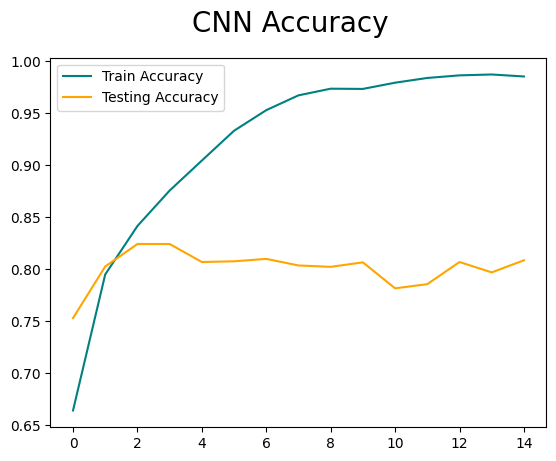

In [111]:
fig_1 = plt.figure()
plt.plot(hist_1.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_1.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_1.suptitle('CNN Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [112]:
hist_2 = cnn_model_reg.fit(train_scaled_data, epochs= 15, validation_data= test_scaled_data, callbacks=[tensorboard_callback_reg])

Epoch 1/15
439/439 [==============================] - 50s 111ms/step - loss: 0.4252 - accuracy: 0.1631 - val_loss: 0.4046 - val_accuracy: 0.1373
Epoch 2/15
439/439 [==============================] - 48s 109ms/step - loss: 0.4121 - accuracy: 0.1536 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 3/15
439/439 [==============================] - 47s 107ms/step - loss: 0.4121 - accuracy: 0.1561 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 4/15
439/439 [==============================] - 47s 106ms/step - loss: 0.4121 - accuracy: 0.1565 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 5/15
439/439 [==============================] - 44s 101ms/step - loss: 0.4121 - accuracy: 0.1642 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 6/15
439/439 [==============================] - 47s 107ms/step - loss: 0.4121 - accuracy: 0.1655 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 7/15
439/439 [==============================] - 51s 116ms/step - loss: 0.4121 - accuracy: 0.1613 - val_loss: 0.4046 - val_ac

# CNN-SVM accuracy Details

### Numbers are very bad and are looking similar to the PCA-SVM model that we had built earlier

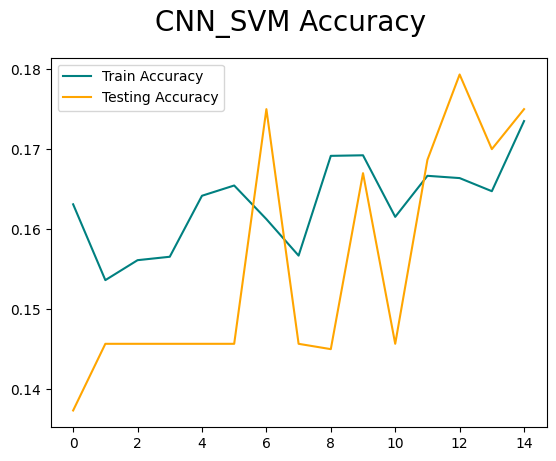

In [113]:
fig_2 = plt.figure()
plt.plot(hist_2.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_2.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_2.suptitle('CNN-SVM Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [114]:
hist_3 = cnn_model_pca.fit(x = pca_train_data_reshaped_X, y = train_data_y, epochs = 15, validation_data = (pca_test_data_reshaped_X, test_data_y), callbacks=[tensorboard_callback_pca])

Epoch 1/15
439/439 [==============================] - 4s 8ms/step - loss: 1.2493 - accuracy: 0.5088 - val_loss: 1.6051 - val_accuracy: 0.3903
Epoch 2/15
439/439 [==============================] - 3s 7ms/step - loss: 1.0712 - accuracy: 0.5891 - val_loss: 1.7041 - val_accuracy: 0.3820
Epoch 3/15
439/439 [==============================] - 3s 8ms/step - loss: 1.0014 - accuracy: 0.6131 - val_loss: 1.5899 - val_accuracy: 0.3983
Epoch 4/15
439/439 [==============================] - 3s 8ms/step - loss: 0.9455 - accuracy: 0.6401 - val_loss: 1.8114 - val_accuracy: 0.3563
Epoch 5/15
439/439 [==============================] - 3s 7ms/step - loss: 0.9031 - accuracy: 0.6604 - val_loss: 1.6859 - val_accuracy: 0.3940
Epoch 6/15
439/439 [==============================] - 3s 8ms/step - loss: 0.8580 - accuracy: 0.6768 - val_loss: 1.8531 - val_accuracy: 0.4030
Epoch 7/15
439/439 [==============================] - 3s 8ms/step - loss: 0.8234 - accuracy: 0.6894 - val_loss: 1.8826 - val_accuracy: 0.3820
Epoch 

# CNN-PCA Accuracies details
### Underwhelming Training accuracies and Very Poor testing accuracies
### Not a useful model at all

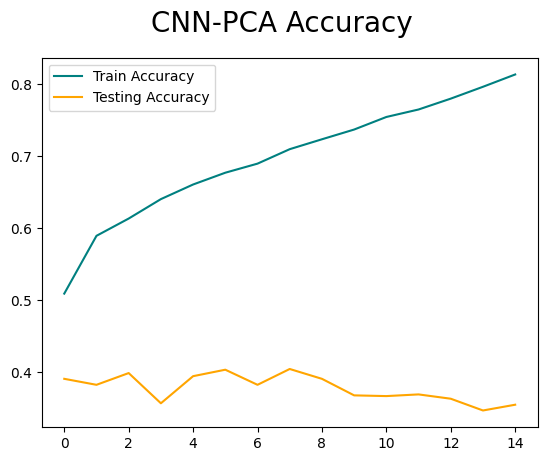

In [151]:
fig_3 = plt.figure()
plt.plot(hist_3.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_3.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_3.suptitle('CNN-PCA Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [116]:
hist_4 = cnn_model_pca_reg.fit(x = pca_train_data_reshaped_X, y = train_data_y, epochs = 15, validation_data = (pca_test_data_reshaped_X, test_data_y), callbacks=[tensorboard_callback_pca_reg])

Epoch 1/15
439/439 [==============================] - 5s 8ms/step - loss: 0.4271 - accuracy: 0.1717 - val_loss: 0.4046 - val_accuracy: 0.1747
Epoch 2/15
439/439 [==============================] - 4s 8ms/step - loss: 0.4121 - accuracy: 0.1735 - val_loss: 0.4046 - val_accuracy: 0.1627
Epoch 3/15
439/439 [==============================] - 3s 8ms/step - loss: 0.4121 - accuracy: 0.1622 - val_loss: 0.4046 - val_accuracy: 0.1423
Epoch 4/15
439/439 [==============================] - 3s 8ms/step - loss: 0.4121 - accuracy: 0.1531 - val_loss: 0.4046 - val_accuracy: 0.1460
Epoch 5/15
439/439 [==============================] - 3s 8ms/step - loss: 0.4121 - accuracy: 0.1541 - val_loss: 0.4046 - val_accuracy: 0.1467
Epoch 6/15
439/439 [==============================] - 4s 8ms/step - loss: 0.4121 - accuracy: 0.1535 - val_loss: 0.4046 - val_accuracy: 0.1463
Epoch 7/15
439/439 [==============================] - 3s 8ms/step - loss: 0.4121 - accuracy: 0.1526 - val_loss: 0.4046 - val_accuracy: 0.1430
Epoch 

# CNN-PCA-SVM Accuracies Details
### Same as the CNN-SVM model Numbers. Very poor and not very useful model at all

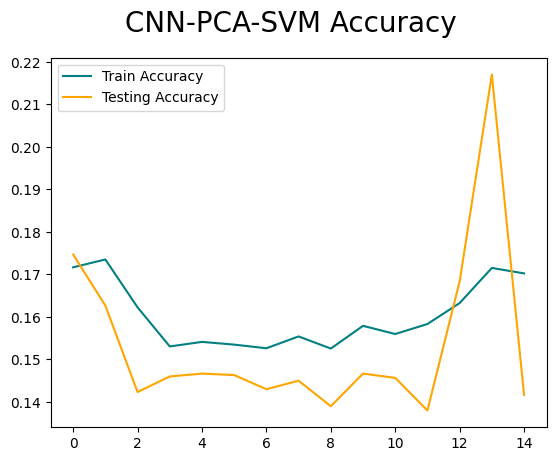

In [152]:
fig_4 = plt.figure()
plt.plot(hist_4.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_4.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_4.suptitle('CNN-PCA-SVM Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [118]:
hist_5 = cnn_model_drop_reg.fit(train_scaled_data, epochs= 15, validation_data= test_scaled_data, callbacks=[tensorboard_callback_drop_reg])

Epoch 1/15
439/439 [==============================] - 54s 119ms/step - loss: 0.4282 - accuracy: 0.1841 - val_loss: 0.4047 - val_accuracy: 0.1740
Epoch 2/15
439/439 [==============================] - 52s 118ms/step - loss: 0.4121 - accuracy: 0.1241 - val_loss: 0.4046 - val_accuracy: 0.1577
Epoch 3/15
439/439 [==============================] - 52s 117ms/step - loss: 0.4121 - accuracy: 0.1103 - val_loss: 0.4046 - val_accuracy: 0.1420
Epoch 4/15
439/439 [==============================] - 51s 115ms/step - loss: 0.4121 - accuracy: 0.1312 - val_loss: 0.4046 - val_accuracy: 0.1580
Epoch 5/15
439/439 [==============================] - 51s 115ms/step - loss: 0.4121 - accuracy: 0.1572 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 6/15
439/439 [==============================] - 52s 119ms/step - loss: 0.4121 - accuracy: 0.1587 - val_loss: 0.4046 - val_accuracy: 0.1457
Epoch 7/15
439/439 [==============================] - 52s 118ms/step - loss: 0.4121 - accuracy: 0.1554 - val_loss: 0.4046 - val_ac

# CNN-SVM (Neurons Dropout) model accuracy details

## At this point there is a pattern emerging, that SVM is not at all suitable for the Large Dataset multi class image classifications (Very disappointing to find out)

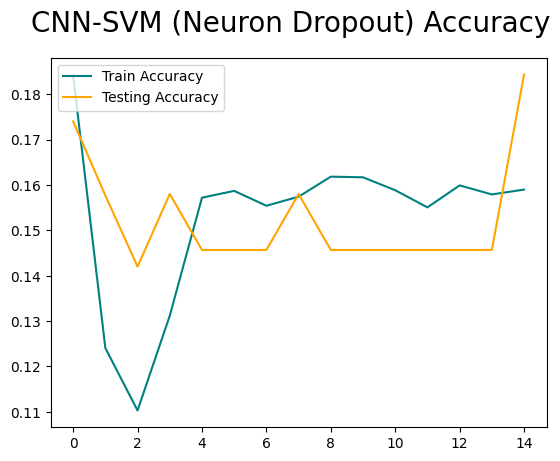

In [153]:
fig_5 = plt.figure()
plt.plot(hist_5.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_5.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_5.suptitle('CNN-SVM (Neuron Dropout) Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [120]:
hist_6 = cnn_model_pca_drop_reg.fit(x = pca_train_data_reshaped_X, y = train_data_y, epochs = 15, validation_data = (pca_test_data_reshaped_X, test_data_y), callbacks=[tensorboard_callback_pca_drop_reg])

Epoch 1/15
439/439 [==============================] - 6s 9ms/step - loss: 0.4306 - accuracy: 0.1745 - val_loss: 0.4047 - val_accuracy: 0.1660
Epoch 2/15
439/439 [==============================] - 4s 8ms/step - loss: 0.4121 - accuracy: 0.1731 - val_loss: 0.4046 - val_accuracy: 0.1603
Epoch 3/15
439/439 [==============================] - 4s 9ms/step - loss: 0.4121 - accuracy: 0.1641 - val_loss: 0.4046 - val_accuracy: 0.1633
Epoch 4/15
439/439 [==============================] - 4s 8ms/step - loss: 0.4121 - accuracy: 0.1580 - val_loss: 0.4046 - val_accuracy: 0.1640
Epoch 5/15
439/439 [==============================] - 4s 9ms/step - loss: 0.4121 - accuracy: 0.1632 - val_loss: 0.4046 - val_accuracy: 0.1583
Epoch 6/15
439/439 [==============================] - 4s 9ms/step - loss: 0.4121 - accuracy: 0.1630 - val_loss: 0.4046 - val_accuracy: 0.1677
Epoch 7/15
439/439 [==============================] - 4s 9ms/step - loss: 0.4121 - accuracy: 0.1610 - val_loss: 0.4046 - val_accuracy: 0.1483
Epoch 

# CNN-PCA-SVM Model (Neuron Dropout) accuracies model

### Same as the other two SVM involved models, numbers are not good at all.

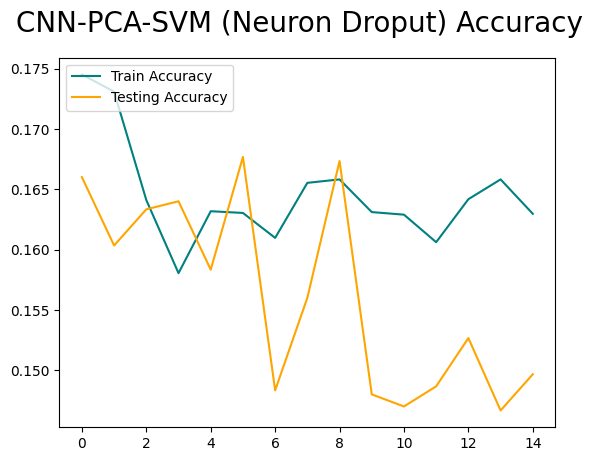

In [154]:
fig_6 = plt.figure()
plt.plot(hist_6.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_6.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_6.suptitle('CNN-PCA-SVM (Neuron Droput) Accuracy', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

In [122]:
hist_7 = cnn_drop_model.fit(train_scaled_data, epochs= 15, validation_data= test_scaled_data, callbacks=[tensorboard_callback_drop])

Epoch 1/15
439/439 [==============================] - 57s 126ms/step - loss: 0.9391 - accuracy: 0.6377 - val_loss: 0.7801 - val_accuracy: 0.7133
Epoch 2/15
439/439 [==============================] - 55s 125ms/step - loss: 0.6468 - accuracy: 0.7628 - val_loss: 0.6317 - val_accuracy: 0.7717
Epoch 3/15
439/439 [==============================] - 58s 133ms/step - loss: 0.5346 - accuracy: 0.8062 - val_loss: 0.5618 - val_accuracy: 0.7997
Epoch 4/15
439/439 [==============================] - 56s 128ms/step - loss: 0.4802 - accuracy: 0.8243 - val_loss: 0.5252 - val_accuracy: 0.8050
Epoch 5/15
439/439 [==============================] - 61s 139ms/step - loss: 0.4119 - accuracy: 0.8467 - val_loss: 0.5298 - val_accuracy: 0.8120
Epoch 6/15
439/439 [==============================] - 60s 136ms/step - loss: 0.3557 - accuracy: 0.8678 - val_loss: 0.4714 - val_accuracy: 0.8383
Epoch 7/15
439/439 [==============================] - 54s 123ms/step - loss: 0.3042 - accuracy: 0.8892 - val_loss: 0.5639 - val_ac

# CNN (Neuron Dropout) Model Accuracy Details

### Even after dropping the Neurons, which was one of the solution to reduce overfitting, we are seeing the same issue.
### But this is one of out best models along with the normal CNN model

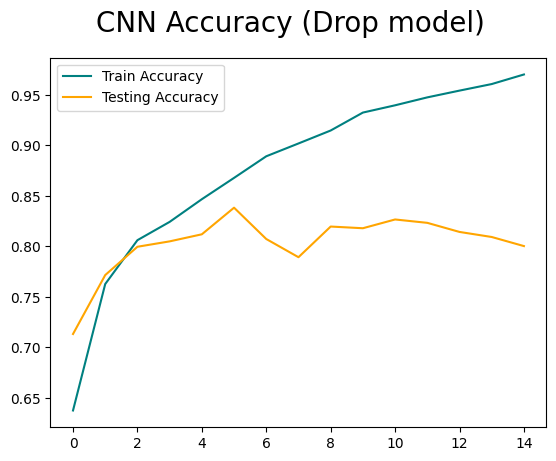

In [123]:
fig_7 = plt.figure()
plt.plot(hist_7.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_7.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_7.suptitle('CNN Accuracy (Drop model)', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# Brain tumor Model building

## After running our seven different CNN models we have finally come to find out that only two of the seven models built were performing better
## CNN and CNN (NeuronDropout)
## Evnthough the CNN-PCA model had noticable training accuracy, but the testing accuracies were nowhere near considerable

## Loading the Train and test data of Brain Tumors, we have 4 different classifications, one with no Tumor brain Images and 3 classes are the tumor involved images 
## Images are MRI scans of Brain

## We will train our brain tumors data using the above selected two models

In [140]:
train_brain_data = tf.keras.utils.image_dataset_from_directory("data\Brain_tumors\Training", image_size = (350, 350))
test_brain_data = tf.keras.utils.image_dataset_from_directory("data\Brain_tumors\Testing", image_size= (350, 350))

Found 2870 files belonging to 4 classes.
Found 394 files belonging to 4 classes.


### Data Scaling

In [141]:
brain_train_scaled_data = train_brain_data.map(lambda x,y: (x/255, y))
brain_test_scaled_data = test_brain_data.map(lambda i, j: (i/255, j))

brain_train_scaled_data_iterator = brain_train_scaled_data.as_numpy_iterator()
brain_test_scaled_data_iterator = brain_test_scaled_data.as_numpy_iterator()

brain_train_scaled_batch = brain_train_scaled_data_iterator.next()
brain_test_scaled_batch = brain_test_scaled_data_iterator.next()

In [142]:
cnn_brain = Sequential()
cnn_brain_drop = Sequential()

In [143]:
cnn_brain.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (350, 350, 3), padding = 'same'))
cnn_brain.add(MaxPooling2D(padding = 'same'))

cnn_brain.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_brain.add(MaxPooling2D(padding = 'same'))

cnn_brain.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_brain.add(MaxPooling2D(padding = 'same'))

cnn_brain.add(Flatten())

cnn_brain.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_brain.add(Dense(4, activation = 'softmax'))

In [144]:
cnn_brain_drop.add(Conv2D(16, (3, 3), 1, activation = 'relu', input_shape = (350, 350, 3), padding = 'same'))
cnn_brain_drop.add(MaxPooling2D(padding = 'same'))

cnn_brain_drop.add(Conv2D(32, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_brain_drop.add(MaxPooling2D(padding = 'same'))

cnn_brain_drop.add(Dropout(0.5))

cnn_brain_drop.add(Conv2D(16, (3, 3), 1, activation = 'relu', padding = 'same'))
cnn_brain_drop.add(MaxPooling2D(padding = 'same'))

cnn_brain_drop.add(Flatten())

cnn_brain_drop.add(Dense(256, kernel_initializer = 'he_normal', activation = 'relu'))
cnn_brain_drop.add(Dense(4, activation = 'softmax'))

In [145]:
cnn_brain.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
cnn_brain_drop.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [146]:
logdir_brain = os.path.join('logs', 'brain_normal',  '')
logdir_brain_drop = os.path.join('logs', 'brain_drop', '')

tensorboard_callback_brain = tf.keras.callbacks.TensorBoard(log_dir = logdir_brain)
tensorboard_callback_brain_drop = tf.keras.callbacks.TensorBoard(log_dir = logdir_brain_drop)

In [147]:
hist_brain = cnn_brain.fit(brain_train_scaled_data, epochs= 20, validation_data= brain_test_scaled_data, callbacks=[tensorboard_callback_brain])

Epoch 1/20
90/90 [==============================] - 52s 555ms/step - loss: 0.9098 - accuracy: 0.6240 - val_loss: 1.7465 - val_accuracy: 0.5178
Epoch 2/20
90/90 [==============================] - 48s 525ms/step - loss: 0.3648 - accuracy: 0.8599 - val_loss: 1.8131 - val_accuracy: 0.6294
Epoch 3/20
90/90 [==============================] - 48s 534ms/step - loss: 0.1589 - accuracy: 0.9443 - val_loss: 2.6527 - val_accuracy: 0.7284
Epoch 4/20
90/90 [==============================] - 46s 505ms/step - loss: 0.0717 - accuracy: 0.9756 - val_loss: 4.1624 - val_accuracy: 0.6827
Epoch 5/20
90/90 [==============================] - 47s 515ms/step - loss: 0.0498 - accuracy: 0.9864 - val_loss: 4.1797 - val_accuracy: 0.7462
Epoch 6/20
90/90 [==============================] - 46s 509ms/step - loss: 0.0282 - accuracy: 0.9916 - val_loss: 4.6344 - val_accuracy: 0.7538
Epoch 7/20
90/90 [==============================] - 47s 513ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 5.8372 - val_accuracy: 0.7563

In [148]:
hist_brain_drop = cnn_brain_drop.fit(brain_train_scaled_data, epochs= 15, validation_data= brain_test_scaled_data, callbacks=[tensorboard_callback_brain_drop])

Epoch 1/15
90/90 [==============================] - 56s 600ms/step - loss: 1.1466 - accuracy: 0.5042 - val_loss: 1.4483 - val_accuracy: 0.3350
Epoch 2/15
90/90 [==============================] - 56s 613ms/step - loss: 0.6657 - accuracy: 0.7282 - val_loss: 1.3353 - val_accuracy: 0.3985
Epoch 3/15
90/90 [==============================] - 53s 582ms/step - loss: 0.3875 - accuracy: 0.8544 - val_loss: 1.3535 - val_accuracy: 0.5787
Epoch 4/15
90/90 [==============================] - 55s 602ms/step - loss: 0.2513 - accuracy: 0.9042 - val_loss: 1.3588 - val_accuracy: 0.6675
Epoch 5/15
90/90 [==============================] - 53s 582ms/step - loss: 0.1461 - accuracy: 0.9477 - val_loss: 1.5100 - val_accuracy: 0.6294
Epoch 6/15
90/90 [==============================] - 52s 572ms/step - loss: 0.1099 - accuracy: 0.9613 - val_loss: 1.7812 - val_accuracy: 0.6904
Epoch 7/15
90/90 [==============================] - 52s 574ms/step - loss: 0.0888 - accuracy: 0.9704 - val_loss: 2.0187 - val_accuracy: 0.7335

# CNN model accuracy for Brain Image data
## The Accuracy data that we got from the Normal CNN model is similar to the one we experienced earlier
## Overfitting Training Accuracy and Sub-Par Testing accuracies

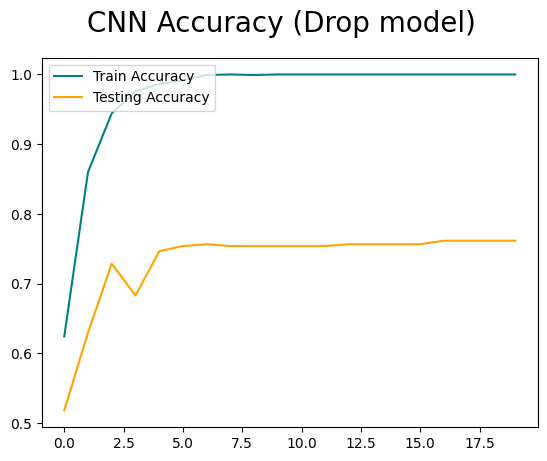

In [149]:
fig_brain = plt.figure()
plt.plot(hist_brain.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_brain.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_brain.suptitle('CNN Accuracy (Drop model)', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# CNN (Neuron Dropout) Model Accuracy details
## Data here is very similar to the earlier model data, The earlier model went into overfitting rather quickly than this model

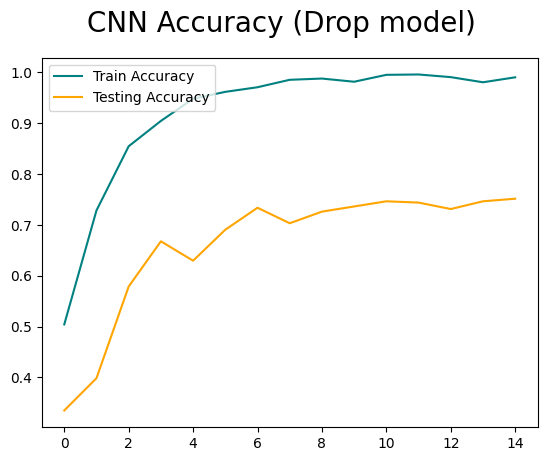

In [150]:
fig_brain_drop = plt.figure()
plt.plot(hist_brain_drop.history['accuracy'], color = 'teal', label = 'Train Accuracy')
plt.plot(hist_brain_drop.history['val_accuracy'], color = 'orange', label = 'Testing Accuracy')
fig_brain_drop.suptitle('CNN Accuracy (Drop model)', fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

# Conclusion

### The PCA-SVM model which we were trying to prove that we can make it better and almost as equal in performance wise to the Deep Learning models was unsuccessful (This was an unexpected surprise.)
### SVM model with all the powerful help of CNN was rather helpless in performance wise.
### CNN with its natural parameters and with a bit more hyperparameter finetuning will be miles a head of SVM.

# Potential Buyer of this project

## At this point, even if I make a beautiful sales pitch, no company would be interested in my product.
## Because the performance of my product is not very good. Eventhough the CNN models have given better results, but they are better Industrial wise.

# --------------------------------------------------------------------------------------------------------------

# What I can do before taking my product to the buyers

## 1. I can train my model using better technique like Data Augmentation (Increarsing Data diversity artificially), using techniques like Ensemble Methods and exploring Advanced architectures
## 2. Prepare all visualisations showing the Performance metrics (Accuracy, Precision, Recall, F1)
## 3. Do some real world testing and save the data for future sales pitch presentations.

# --------------------------------------------------------------------------------------------------------------

# Potential Buyers

## Since my product is all about image related. I need to find industries that Involve ImageData (Medical Imaging, e-commerce(product recognition), Maufacturing companies (Part defect detection))
## I can pitch my product to the companies that have an intense Reasearch and Development department that involve image analysis or pattern recognition

# Examples of Buyers: 
## e-commerce - Amazon, e-bay etc:
## Automotive - Ford, Honda, etc:
## Medical Imaging - Siemens Healthineers, Roche etc:

# How would I sell it?

## Highlight the benefits by showcasing the real world examples where my product was helpful.
## Explain how my product would make a business impact, with the increased efficiency would result in companies Revenue Growth.
## The ease of integration and scalability of my product
## I would compare my product pricing plans compared to the other competetors in the market.
## Be transperant to build a long-term relationship